In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import folium
import openrouteservice as ors
from folium import plugins
import os

In [45]:
ruta_base = os.getcwd()

In [46]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'La Paz, Baja California Sur',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]


In [47]:
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

In [48]:
np.random.seed(42)

In [49]:
COSTO_COMBUSTIBLE = 23.96
RENDIMIENTO_AUTO = 20.69
VALOR_HORA = 35

## Costo 32 estados

In [50]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

In [51]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [52]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [53]:
matriz_costos = pd.read_excel("matriz_costos.xlsx", index_col=0)
ciudades = matriz_costos.index

In [54]:
NUM_HORMIGAS = 32
ALFA = 1  
BETA = 2  
EVAPORACION = 0.5
ITERACIONES = 500
Q = 100 

In [55]:
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))
mejor_ruta = None
mejor_costo = float("inf")

In [56]:
def calcular_probabilidades(actual, visitados):
    """
    Calcular las probabilidades de ir de la ciudad actual a las no visitadas.
    """
    heuristica = 1.0 / (matriz_costos.values[actual] + 1e-10)  # Inverso del costo
    heuristica[visitados] = 0  # Las ciudades visitadas no son elegibles
    feromonas_actual = feromonas[actual]

    # Calcular probabilidades basadas en feromonas y heurística
    numeradores = (feromonas_actual ** ALFA) * (heuristica ** BETA)
    suma = np.sum(numeradores)
    if suma == 0:
        return np.zeros_like(numeradores)
    return numeradores / suma

def construir_ruta():
    """
    Construir una ruta para una hormiga utilizando las probabilidades y volviendo al origen.
    """
    ciudad_inicial = np.random.randint(num_ciudades)
    ruta = [ciudad_inicial]
    while len(ruta) < num_ciudades:
        actual = ruta[-1]
        probabilidades = calcular_probabilidades(actual, ruta)
        siguiente = np.random.choice(range(num_ciudades), p=probabilidades)
        ruta.append(siguiente)
    
    # Agregar la ciudad inicial al final para completar el ciclo
    ruta.append(ciudad_inicial)
    return ruta

def calcular_costo(ruta):
    """
    Calcular el costo total de una ruta.
    """
    costo = 0
    for i in range(len(ruta) - 1):
        costo += matriz_costos.iloc[ruta[i], ruta[i + 1]]
    return costo  # Ya no necesitamos agregar el costo de vuelta al inicio aquí

def actualizar_feromonas(solutions):
    """
    Actualizar las feromonas basado en las soluciones encontradas.
    """
    global feromonas
    # Evaporar feromonas
    feromonas *= (1 - EVAPORACION)

    # Depositar nuevas feromonas
    for ruta, costo in solutions:
        for i in range(len(ruta) - 1):
            feromonas[ruta[i], ruta[i + 1]] += Q / costo

np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()  # Ahora incluye el retorno a la ciudad inicial
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

In [57]:
mejor_ruta = [ciudades[i] for i in mejor_ruta]

In [58]:
print("Mejor ruta encontrada:", mejor_ruta)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Tuxtla Gutiérrez', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Villahermosa', 'Oaxaca de Juárez', 'Chilpancingo de los Bravo', 'Santiago de Querétaro', 'Guanajuato', 'San Luis Potosí', 'Aguascalientes', 'Zacatecas', 'Victoria de Durango', 'Saltillo', 'Monterrey', 'Ciudad Victoria', 'Pachuca de Soto', 'Chihuahua', 'Hermosillo', 'Mexicali', 'La Paz', 'Culiacán Rosales', 'Tepic', 'Colima', 'Guadalajara', 'Morelia', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Heroica Puebla de Zaragoza', 'Tlaxcala de Xicohténcatl', 'Xalapa-Enríquez', 'Tuxtla Gutiérrez']
Costo total: 28940.998711132594


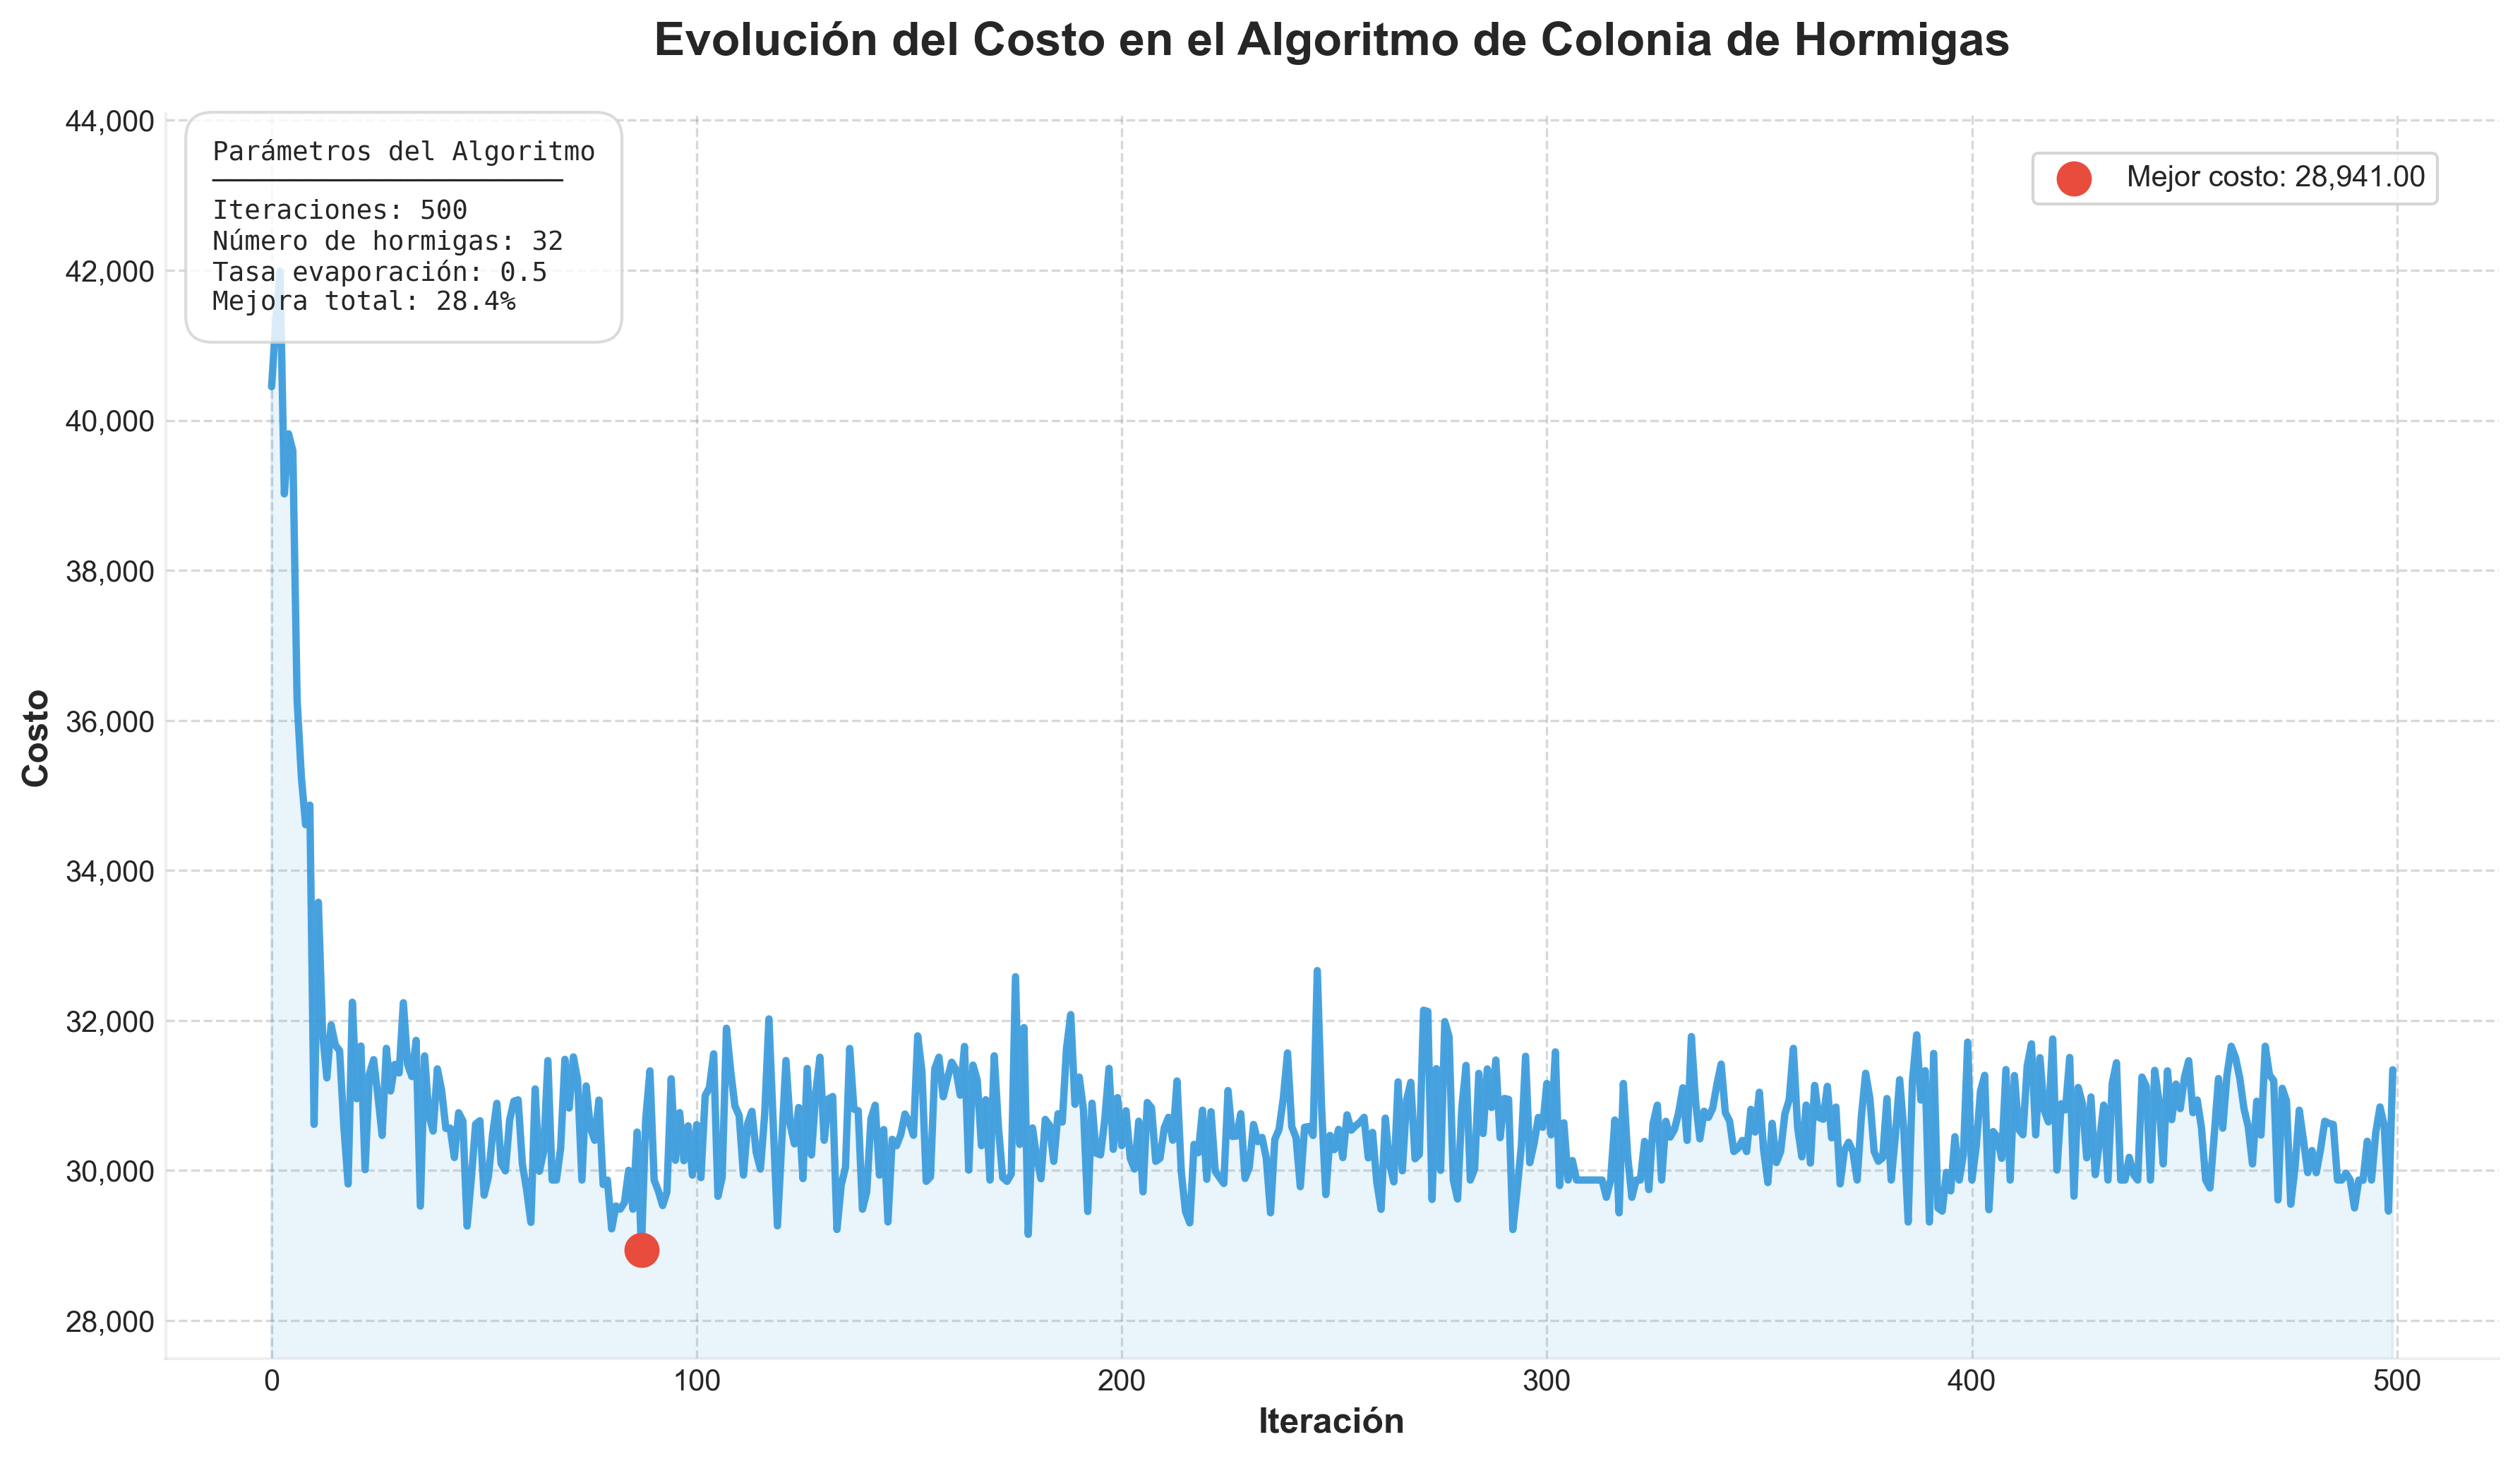

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar_evolucion_aco(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    """
    Crea una visualización detallada de la evolución del algoritmo ACO.
    
    Args:
        historial_costos: Lista de listas con los costos de cada hormiga por iteración
        mejor_costo: El mejor costo encontrado en toda la ejecución
        iteraciones: Número total de iteraciones
        num_hormigas: Número de hormigas utilizadas
        tasa_evaporacion: Tasa de evaporación de feromonas
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Marcar mejor costo
    idx_mejor = mejores_costos_iter.index(mejor_costo)
    ax.scatter(idx_mejor, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Configuración de la cuadrícula
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configuración de ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar bordes
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_alpha(0.3)
    
    # Formato de números en eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajuste de límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Cuadro de parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajuste de márgenes
    plt.tight_layout()
    
    # Guardar gráfico
    plt.savefig('evolucion_costos_aco_all.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Ejemplo de uso:
visualizar_evolucion_aco(
     historial_costos,
     mejor_costo,
     ITERACIONES,
     NUM_HORMIGAS,
     EVAPORACION
)

In [60]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)
        

# Construir la ruta relativa para guardar el archivo
ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades.html"))

# Crear las carpetas necesarias si no existen
os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

# Guardar el archivo HTML
mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [61]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)



ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_con_api.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)


# Guardar el mapa como HTML
mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: U

## Costo 32 estados incluyendo el ferry

In [62]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'La Paz, Baja California Sur',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]

In [63]:
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

In [64]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

In [65]:
peajes.iloc[24, 2] = peajes.iloc[24, 2] + 5480 + 1460

In [66]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos_ferry.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [67]:
matriz_costos = pd.read_excel("matriz_costos_ferry.xlsx", index_col=0)
ciudades = matriz_costos.index

In [68]:
np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

In [69]:
mejor_ruta = [ciudades[i] for i in mejor_ruta]

In [70]:
print("Mejor ruta encontrada:", mejor_ruta)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Culiacán Rosales', 'Tepic', 'Colima', 'Guadalajara', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Villahermosa', 'Tuxtla Gutiérrez', 'Oaxaca de Juárez', 'Xalapa-Enríquez', 'Tlaxcala de Xicohténcatl', 'Heroica Puebla de Zaragoza', 'Chilpancingo de los Bravo', 'Cuernavaca', 'CDMX', 'Toluca de Lerdo', 'Morelia', 'Santiago de Querétaro', 'Guanajuato', 'San Luis Potosí', 'Aguascalientes', 'Zacatecas', 'Victoria de Durango', 'Saltillo', 'Monterrey', 'Ciudad Victoria', 'Pachuca de Soto', 'Chihuahua', 'Hermosillo', 'Mexicali', 'La Paz', 'Culiacán Rosales']
Costo total: 28932.07656677944


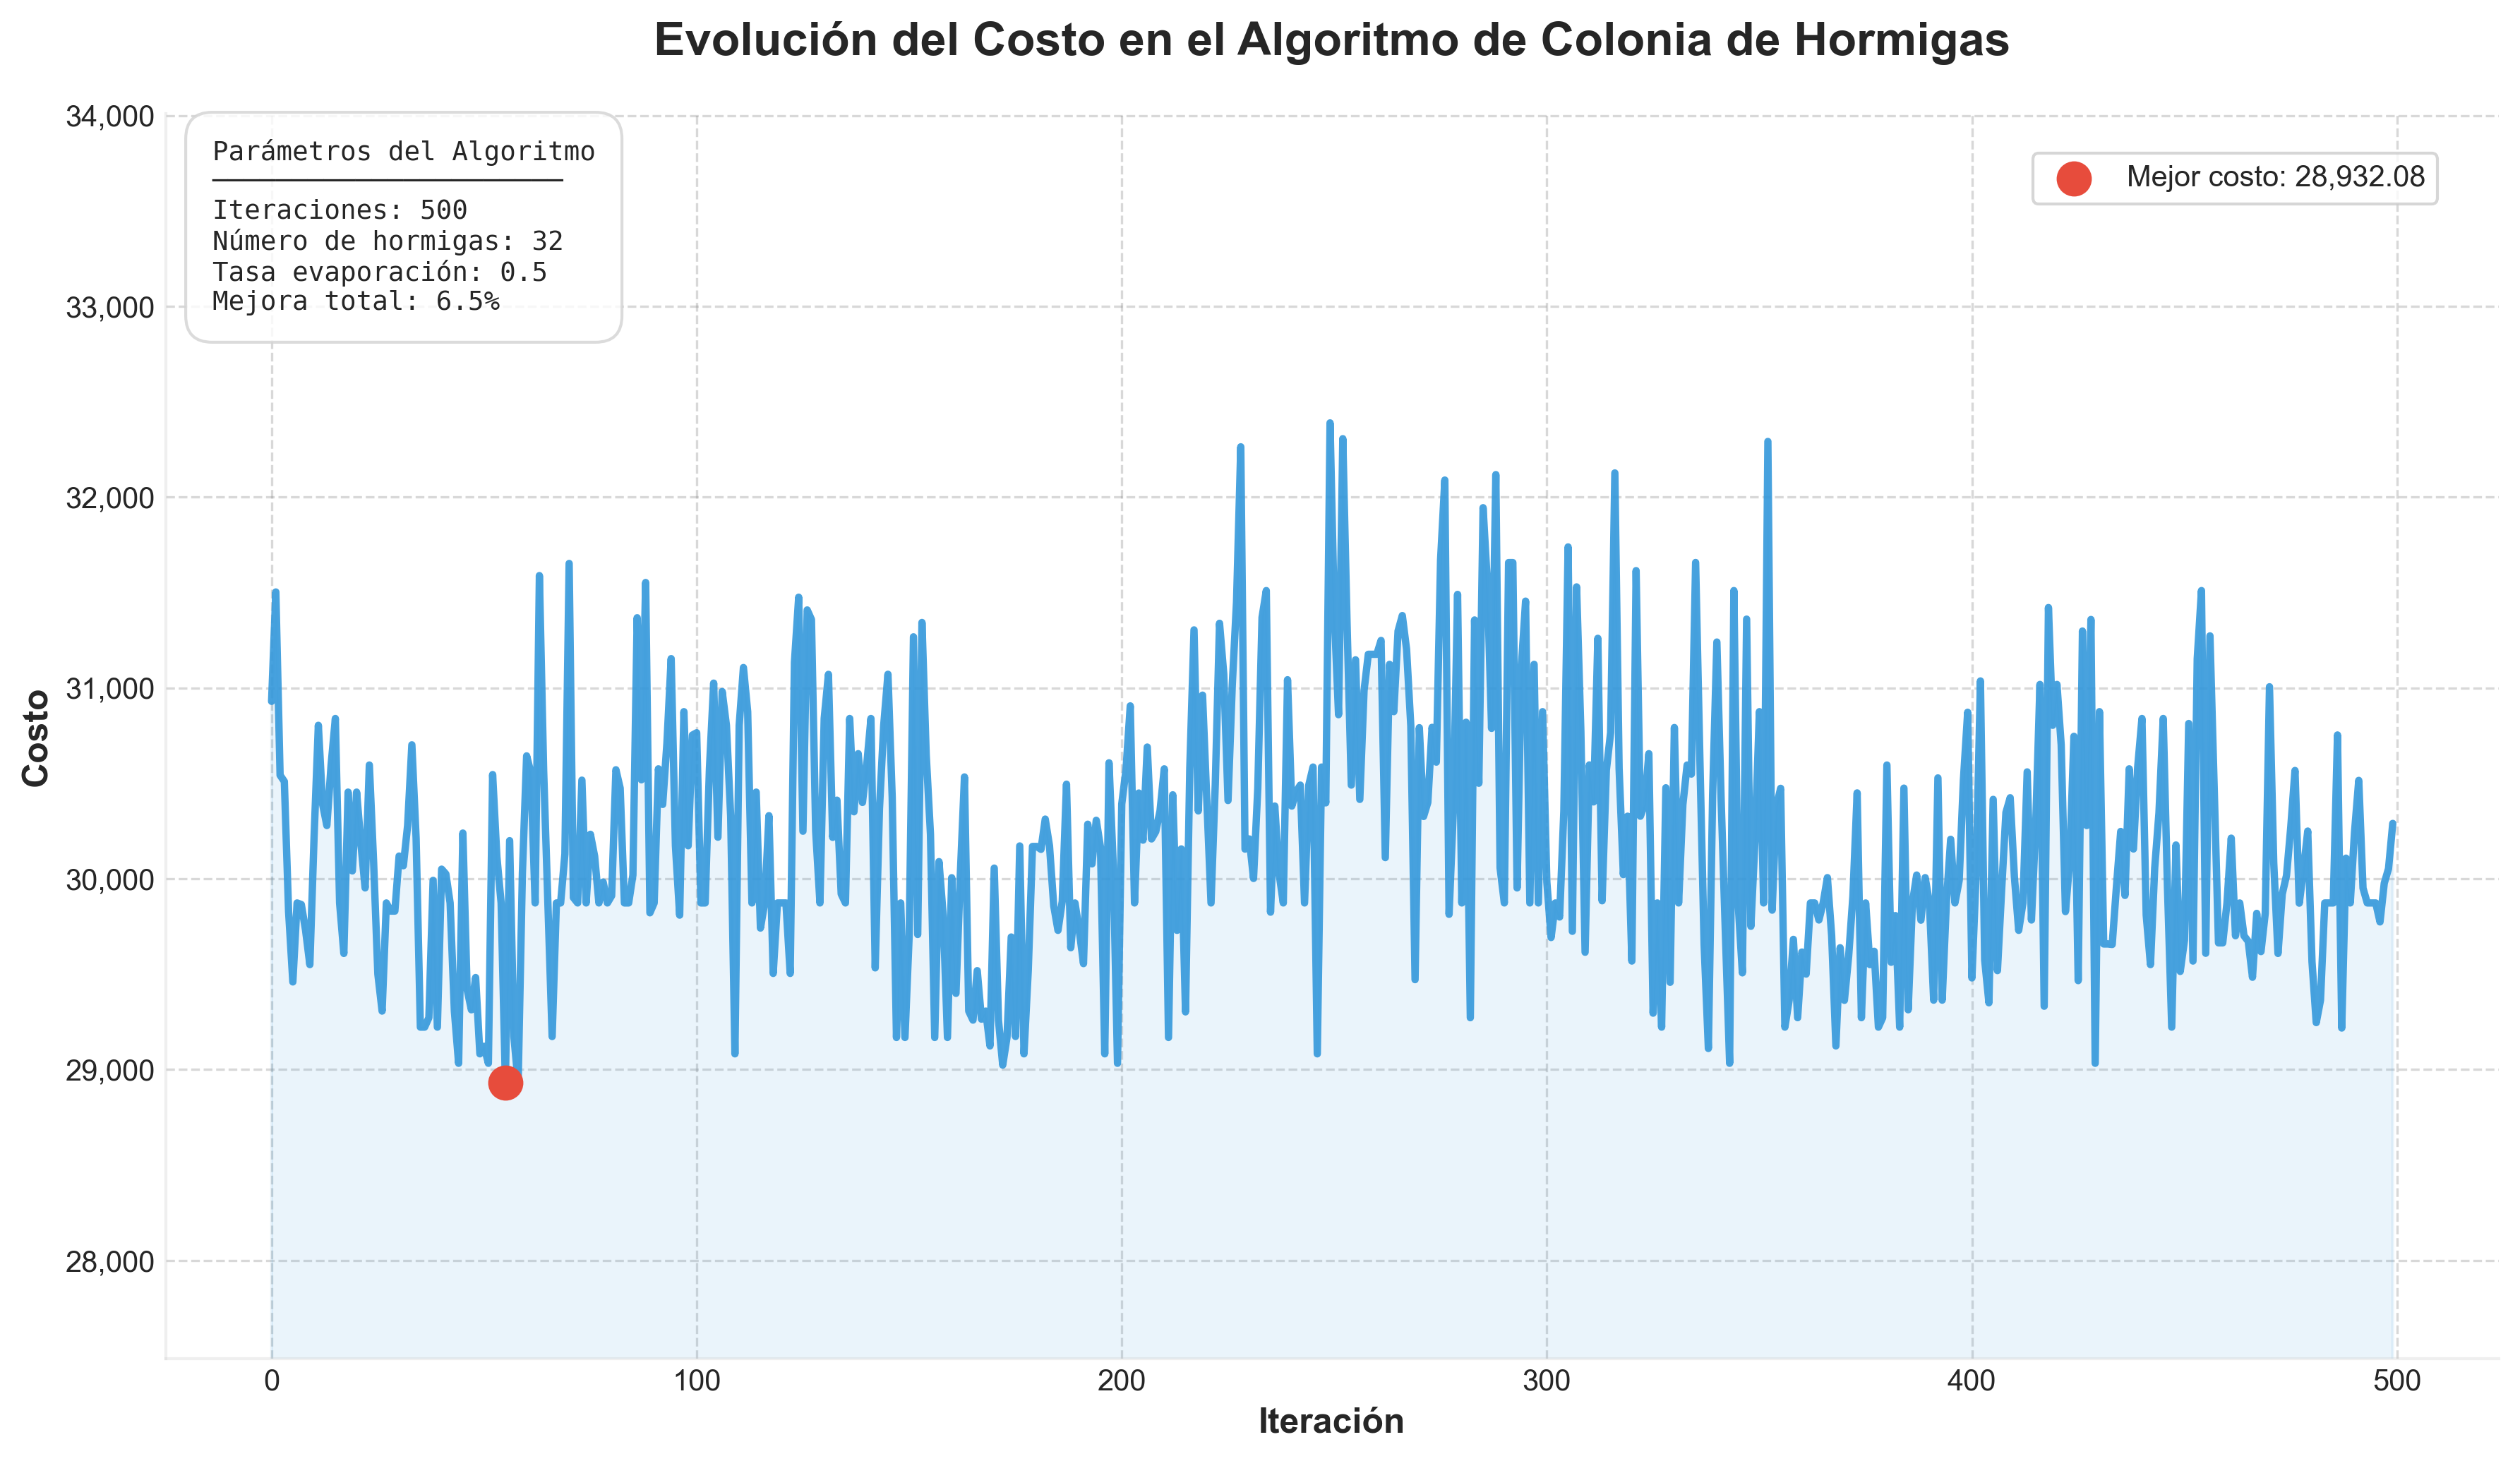

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar_evolucion_aco(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    """
    Crea una visualización detallada de la evolución del algoritmo ACO.
    
    Args:
        historial_costos: Lista de listas con los costos de cada hormiga por iteración
        mejor_costo: El mejor costo encontrado en toda la ejecución
        iteraciones: Número total de iteraciones
        num_hormigas: Número de hormigas utilizadas
        tasa_evaporacion: Tasa de evaporación de feromonas
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Marcar mejor costo
    idx_mejor = mejores_costos_iter.index(mejor_costo)
    ax.scatter(idx_mejor, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Configuración de la cuadrícula
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configuración de ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar bordes
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_alpha(0.3)
    
    # Formato de números en eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajuste de límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Cuadro de parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajuste de márgenes
    plt.tight_layout()
    
    # Guardar gráfico
    plt.savefig('evolucion_costos_aco_ferry.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Ejemplo de uso:
visualizar_evolucion_aco(
     historial_costos,
     mejor_costo,
     ITERACIONES,
     NUM_HORMIGAS,
     EVAPORACION
)

In [72]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)


ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_ferry.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [73]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)

ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_ferry_con_api.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: U

## Costo 31 ciudades

In [74]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]

In [75]:
np.random.seed(42)

In [76]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

# Eliminar la fila y columna llamada "La Paz"
distancias = distancias.drop(index="La Paz", columns="La Paz")
tiempos = tiempos.drop(index="La Paz", columns="La Paz")
peajes = peajes.drop(index="La Paz", columns="La Paz")


In [77]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [78]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos_31.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos_31.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos_31.xlsx'


In [79]:
matriz_costos = pd.read_excel("matriz_costos_31.xlsx", index_col=0)
ciudades = matriz_costos.index

In [80]:
NUM_HORMIGAS = 31
ALFA = 1  
BETA = 2  
EVAPORACION = 0.5
ITERACIONES = 500
Q = 100 

In [81]:
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))
mejor_ruta = None
mejor_costo = float("inf")

In [82]:
np.random.seed(42)

historial_costos = []
historial_mejor_costo = []

for _ in range(ITERACIONES):
    soluciones = []
    costos_iteracion = []
    for _ in range(NUM_HORMIGAS):
        ruta = construir_ruta()
        costo = calcular_costo(ruta)
        soluciones.append((ruta, costo))
        costos_iteracion.append(costo)
        
        if costo < mejor_costo:
            mejor_ruta, mejor_costo = ruta, costo
    
    historial_costos.append(costos_iteracion)
    historial_mejor_costo.append(mejor_costo)

    actualizar_feromonas(soluciones)

mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]
print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo total:", mejor_costo)

Mejor ruta encontrada: ['Xalapa-Enríquez', 'Chilpancingo de los Bravo', 'Santiago de Querétaro', 'San Luis Potosí', 'Aguascalientes', 'Zacatecas', 'Victoria de Durango', 'Saltillo', 'Monterrey', 'Ciudad Victoria', 'Pachuca de Soto', 'Chihuahua', 'Hermosillo', 'Mexicali', 'Culiacán Rosales', 'Tepic', 'Colima', 'Guadalajara', 'Guanajuato', 'Morelia', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Heroica Puebla de Zaragoza', 'Tlaxcala de Xicohténcatl', 'Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Villahermosa', 'Xalapa-Enríquez']
Costo total: 28281.291203479937


In [83]:
mejor_ruta = [ciudades[i] for i in mejor_ruta]

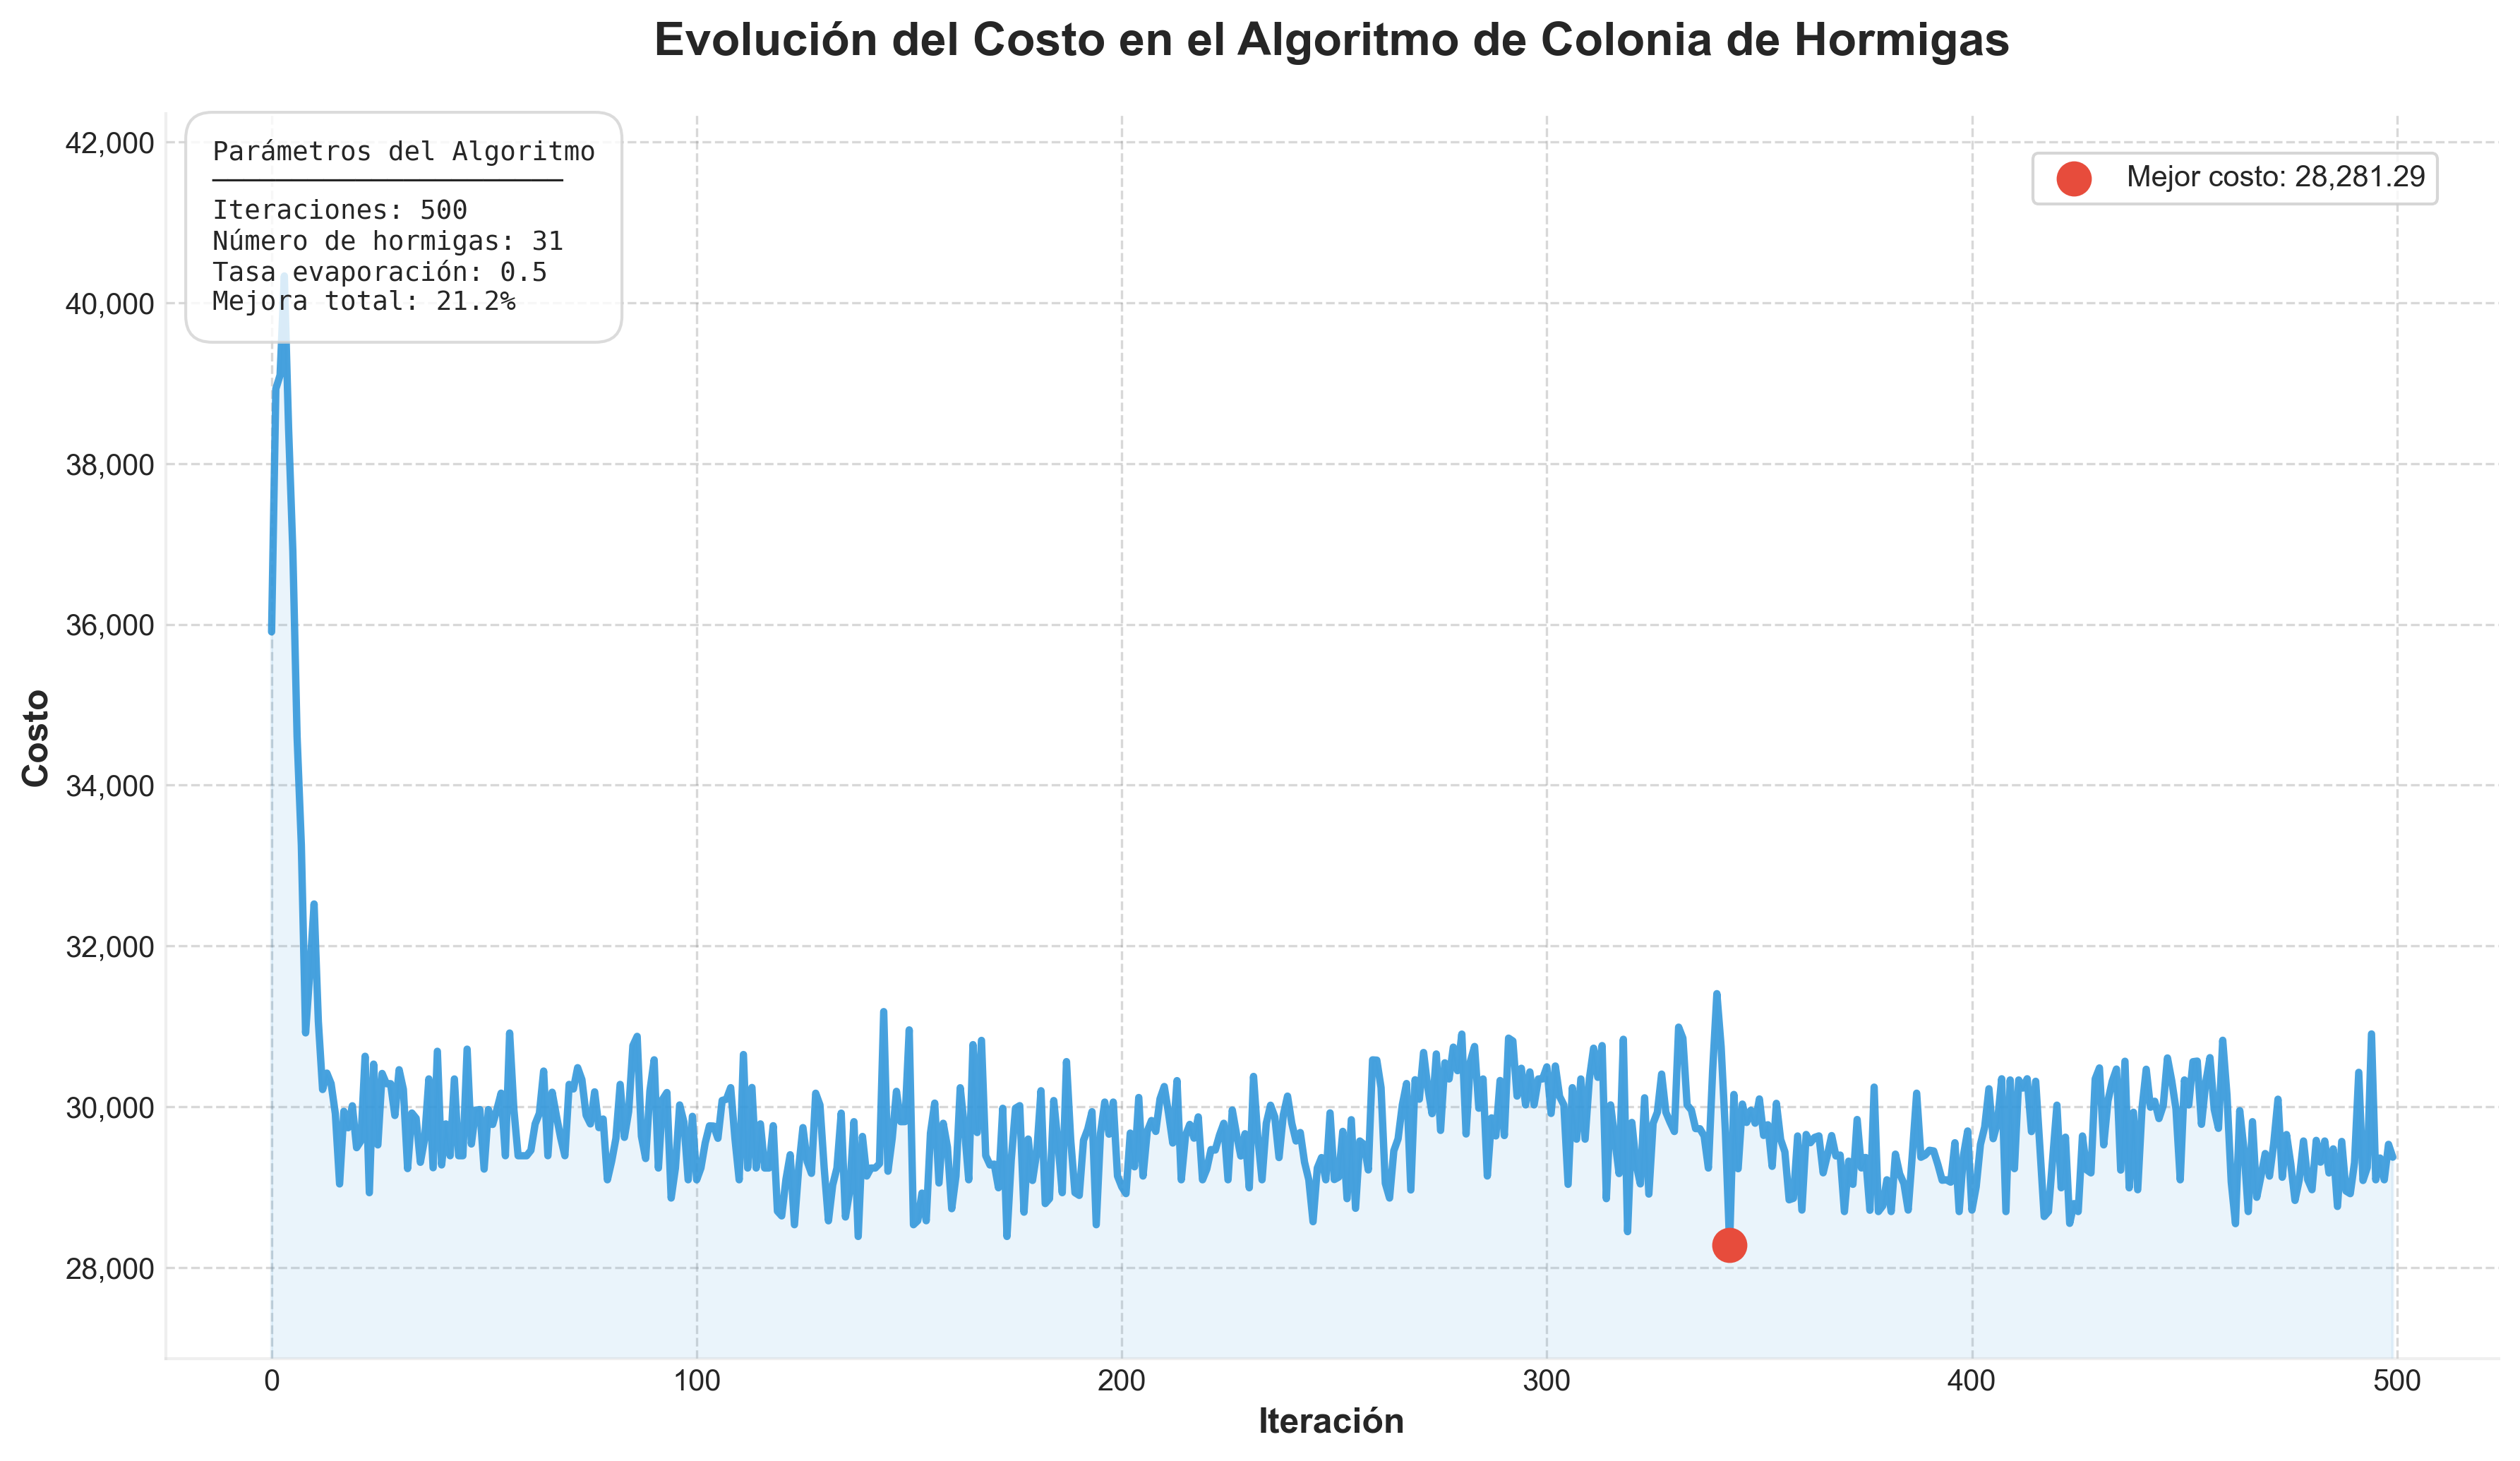

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar_evolucion_aco(historial_costos, mejor_costo, iteraciones, num_hormigas, tasa_evaporacion):
    """
    Crea una visualización detallada de la evolución del algoritmo ACO.
    
    Args:
        historial_costos: Lista de listas con los costos de cada hormiga por iteración
        mejor_costo: El mejor costo encontrado en toda la ejecución
        iteraciones: Número total de iteraciones
        num_hormigas: Número de hormigas utilizadas
        tasa_evaporacion: Tasa de evaporación de feromonas
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos
    mejores_costos_iter = [min(costos) for costos in historial_costos]
    iterations = np.arange(len(mejores_costos_iter))
    
    # Gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, mejores_costos_iter, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Área sombreada bajo la curva
    ax.fill_between(iterations, 
                   mejores_costos_iter, 
                   color=main_color, 
                   alpha=0.1)
    
    # Marcar mejor costo
    idx_mejor = mejores_costos_iter.index(mejor_costo)
    ax.scatter(idx_mejor, 
              mejor_costo,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo:,.2f}')
    
    # Configuración de la cuadrícula
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configuración de ejes
    ax.set_xlabel('Iteración', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar bordes
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_alpha(0.3)
    
    # Formato de números en eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajuste de límites del eje Y
    ymin = min(mejores_costos_iter) * 0.95
    ymax = max(mejores_costos_iter) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título
    plt.title('Evolución del Costo en el Algoritmo de Colonia de Hormigas', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Cuadro de parámetros
    mejora_total = ((mejores_costos_iter[0] - mejor_costo) / mejores_costos_iter[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Iteraciones: {iteraciones}\n'
        f'Número de hormigas: {num_hormigas}\n'
        f'Tasa evaporación: {tasa_evaporacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajuste de márgenes
    plt.tight_layout()
    
    # Guardar gráfico
    plt.savefig('evolucion_costos_aco_31.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Ejemplo de uso:
visualizar_evolucion_aco(
     historial_costos,
     mejor_costo,
     ITERACIONES,
     NUM_HORMIGAS,
     EVAPORACION
)

In [85]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta_ciudades]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)

ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_31.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [86]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta_ciudades]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)


ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_31_con_api.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)



# Guardar el mapa como HTML
mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: U